In [2]:
from custom_tf_idf_transformer_class import CustomClassTfidfTransformer
from write_csv_and_push_data import cleaning_strings

from annoy import AnnoyIndex
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

GET TABLES

In [3]:
julien_products_df = pd.read_csv("/home/jupyter/20231123_stage_vincent_products.csv", sep=",", engine="python")

In [4]:
from cdiscount import config
from cdiscount import snowflake

secrets = config.load_secrets('secrets.yml', key='snowflake')
with snowflake.get_snowflake_connection(**secrets) as con:
    julien_product_seller_df = pd.read_csv("/home/jupyter/20231123_stage_vincent_product_seller_edges.csv", sep=",", engine="python")
    
    lr_df = snowflake.query_snowflake_to_df(
    """
   WITH table_julien AS (
    WITH
        CATEGORY_LEVEL4_PERIMETER AS (
            SELECT DISTINCT PRODUCT_CATEGORY_LEVEL4_ID AS PRODUCT_CATEGORY_LEVEL4_ID
            FROM QUALISCORE_LAB.LAB_STAGE_VINCENT_CANAPES_WITH_PROPERTIES
        ),
        CATEGORY_LEVEL3_PERIMETER AS (
            SELECT DISTINCT
                C.PRODUCT_CATEGORY_LEVEL3_ID,
                C.PRODUCT_CATEGORY_LEVEL4_ID
            FROM CATEGORY_LEVEL4_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL4_ID = C.PRODUCT_CATEGORY_LEVEL4_ID
                AND PRODUCT_CATEGORY_DEPTH = 4
        ),
        CATEGORY_LEVEL3_PATH_PERIMETER AS (
            SELECT
                P.PRODUCT_CATEGORY_LEVEL3_ID,
                P.PRODUCT_CATEGORY_LEVEL4_ID,
                C.PRODUCT_CATEGORY_CODE_PATH
            FROM CATEGORY_LEVEL3_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL3_ID = C.PRODUCT_CATEGORY_LEVEL3_ID
                AND PRODUCT_CATEGORY_DEPTH = 3
        ),
        TRAFFIC AS (
            SELECT
                SEARCH_ID,
                SUM(VIEW_COUNT::FLOAT) AS VIEW_COUNT,
                SUM(CLICK_COUNT) AS CLICK_COUNT,
                SUM(TURNOVER) AS TURNOVER
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_TRACKING_KPI
            WHERE SNAPSHOT_DATE BETWEEN DATE('2023-11-24') - 119 AND DATE('2023-11-24')
                AND SITE_ID = 100
                AND AB_TESTING_GROUP = 'A'
                AND SEARCH_ID <> ''
                AND SEARCH_ID IS NOT NULL
            GROUP BY SEARCH_ID
        ),
        CUMULATIVE_TRAFFIC AS (
            SELECT
                SEARCH_ID,
                (
                    SUM(VIEW_COUNT)
                    OVER(
                        ORDER BY VIEW_COUNT DESC, TURNOVER DESC, CLICK_COUNT DESC
                        ROWS UNBOUNDED PRECEDING
                    )
                ) / (
                    SUM(VIEW_COUNT)
                    OVER()
                ) AS CUM_QP_TRAFFIC
            FROM TRAFFIC
        ),
        TRAFFIC_BINS AS (
            SELECT
                SEARCH_ID,
                FLOOR(
                    IFF(
                        CUM_QP_TRAFFIC = 1,
                        CUM_QP_TRAFFIC - 1e-5,
                        CUM_QP_TRAFFIC
                    ) * 10
                ) AS SEARCH_ID_GROUP
            FROM CUMULATIVE_TRAFFIC
        )
    SELECT
        LR.SEARCH_ID,
        P.PRODUCT_CATEGORY_CODE_PATH
    FROM CATEGORY_LEVEL3_PATH_PERIMETER AS P
    INNER JOIN SEARCH_SMT.SMT_SCH_DIM_SEARCH_LIST_CATEGORY_FILTER AS LR
        ON P.PRODUCT_CATEGORY_CODE_PATH = LR.CATEGORY_FILTER_PATH_CODE
        AND LR.SNAPSHOT_DATE = '2023-11-24'
        AND LR.SITE_ID = 100
        AND LR.AB_TESTING_SVC_COOKIE_GROUP = 'A'
    INNER JOIN TRAFFIC_BINS AS T
        ON LR.SEARCH_ID = T.SEARCH_ID
    WHERE SEARCH_ID_GROUP = 2 or SEARCH_ID_GROUP = 1),
    FULL_DATA AS (
    SELECT     rerank.search_id,
               ARRAY_AGG(DISTINCT rerank.product_id) AS product_id_list,
               page_number
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_PRODUCT_VIEW AS rerank
            JOIN table_julien
                ON table_julien.search_id = rerank.search_id
                WHERE rerank.site_id = 100
                AND rerank.snapshot_date >= DATE('2023-11-24')
            GROUP BY (rerank.search_id, page_number))
    SELECT * FROM full_data WHERE ARRAY_SIZE(product_id_list) >=1;
    """, con=con)
lr_df["product_id_list"] = lr_df.product_id_list.apply(eval)

In [5]:
exploded_lr_df = lr_df.explode("product_id_list")
exploded_lr_df.drop_duplicates(subset=["product_id_list"], inplace=True)
julien_products_df.reset_index(inplace=True)
full_df = julien_products_df.merge(exploded_lr_df, left_on="product_id", right_on="product_id_list")
full_df.rename(columns={'fp_product_name':'product_name', 'product_long_description':'description'}, inplace=True)
full_df.description.fillna("", inplace=True)
full_df.description = cleaning_strings(full_df.description)
full_df.product_name = cleaning_strings(full_df.product_name)
full_df.drop(columns=['product_id_list',
                      'product_short_description',
                      'product_properties',
                      'preprocessed_product_properties',
                      'product_marketing_description',
                      'total_token_fp_product_name',
                      'total_token_product_long_description',
                      'total_token_fp_content',
                      #'community_id'
                     ], inplace=True)

In [6]:
full_df.to_csv("csv_files/lr_products.csv", index=False, sep='\u0001')

ANNOY-ING NEIGHBORS

In [7]:
def id2product_id(index):
    return full_df.iloc[index].product_id

def get_neighbors(u, i, k):
    neighbors, distances = u.get_nns_by_item(i=i, n=k+1, include_distances=True)
    return (
      pd.DataFrame({
          'id': i,
          'neighbor_id': neighbors,
          'distance': distances
      })
      .loc[lambda x: x.neighbor_id.ne(i)]
      .head(k)
      .assign(rank=[j for j in range(1, k+1)])
    )

In [8]:
index_list = full_df["index"]
vec_dim = 1536
original_annoy_index = AnnoyIndex(vec_dim, 'dot')
original_annoy_index.load('/home/jupyter/20231123_stage_vincent_products_fp_content.ann')
u = AnnoyIndex(vec_dim, 'dot')
new_idx = 0
for i in tqdm(index_list, total=len(index_list)):
    vector = original_annoy_index.get_item_vector(i)
    u.add_item(new_idx, vector)
    new_idx += 1
u.build(100)

100%|██████████| 35496/35496 [00:04<00:00, 7210.96it/s]


True

In [9]:
saving_csv=True
all_neighbors = []
for i in tqdm(range(0, u.get_n_items())):
    all_neighbors.append(get_neighbors(u=u, i=i, k=10))
all_neighbors = pd.concat(all_neighbors)
all_neighbors['id'] = all_neighbors['id'].apply(id2product_id)
all_neighbors['neighbor_id'] = all_neighbors['neighbor_id'].apply(id2product_id)
scaler = MinMaxScaler()
all_neighbors['distance'] = scaler.fit_transform(all_neighbors[['distance']])
if saving_csv:
    all_neighbors.to_csv("csv_files/lr_product_product.csv", index=False, sep='\u0001')
    
# all_neighbors[["id", "neighbor_id"]].apply(lambda x: " | ".join(np.sort(x)), axis=1).nunique()

100%|██████████| 35496/35496 [01:12<00:00, 488.24it/s]


In [38]:
product_id = 'ZJC7686514932339'

print(full_df[full_df.product_id == product_id].product_name.item())
for neighbor in all_neighbors[all_neighbors.id == product_id].neighbor_id.tolist():
    print("    ", full_df[full_df.product_id == neighbor].product_name.item())

sib canape lit a 2places et deux oreillers rouge bordeaux velours 7686514932339
     salutuya j2188 canape lit avec_accoudoirs gris fonce velours
     fas canape lit avec_deux oreillers bleu polyester
     canape lit avec_deux oreillers vert polyester 282188 vqu
     canape lit avec_deux oreillers creme polyester 282185 vqu
     dam canape lit avec_deux oreillers marron similicuir 1
     canape lit avec_porte gobelets taupe tissu surenhap liu2943
     vente shop canape a 2places tissu vert vduoeh contemporain
     canape 2places avec_accoudoirs noir chrome et velours pois 236
     pet canape lit avec_accoudoir vert polyester
     lex canape lit avec_porte gobelets jaune clair tissu qqmora tgy670


PUSH TO NEO4J

In [143]:
from neo4j import GraphDatabase, basic_auth
username = "neo4j"
password = "zDje683kEKpo23"
driver = GraphDatabase.driver(uri="bolt://a08datasc002.cdbdx.biz:7687", auth=(username, password))

cleaning_all = '''
MATCH (n)
DETACH DELETE n
'''
products_idx = '''
CREATE INDEX products_constraint IF NOT EXISTS FOR (n:Product) ON n.product_id;
'''
# product_property_value,product_id,product_category_level4_id,product_category_level4_name,product_long_description
create_products_nodes = '''
LOAD CSV WITH HEADERS FROM 'file:///var/lib/neo4j/import/lr_products.csv' AS product_line FIELDTERMINATOR '\u0001'
// Create products
MERGE (p:Product
            {product_id: product_line.product_id,
             product_name: COALESCE(product_line.fp_product_name, "empty"),
             description: COALESCE(product_line.product_long_description, "empty")
             })
'''
product_product_relationship = '''
// Create a relationship between the products
CALL apoc.periodic.iterate(
  '
  LOAD CSV WITH HEADERS FROM "file:///var/lib/neo4j/import/lr_product_product.csv" AS line FIELDTERMINATOR "\u0001"
  RETURN line
  ',
  '
  MATCH (p:Product {product_id: line.id})
  MATCH (neighbor:Product {product_id: line.neighbor_id})
  MERGE (p)-[:Neighbors]->(neighbor)
  MERGE (neighbor)-[:Neighbors]->(p)
  ',
  {batchSize: 5000, iterateList: true}
)
'''

product_product_relationship_weighted = '''
// Create a weighted relationship between the products
CALL apoc.periodic.iterate(
  '
  LOAD CSV WITH HEADERS FROM "file:///var/lib/neo4j/import/lr_product_product.csv" AS line FIELDTERMINATOR "\u0001"
  RETURN line
  ',
  '
  MATCH (p:Product {product_id: line.id})
  MATCH (neighbor:Product {product_id: line.neighbor_id})
  MERGE (p)-[r:Neighbors {weight: toFloat(line.distance)}]->(neighbor)
  MERGE (neighbor)-[:Neighbors {weight: toFloat(line.distance)}]->(p)
  ',
  {batchSize: 5000, iterateList: true}
)
'''

cleaning_before_pushing=True
weighted_relationship=True

with driver.session(database="neo4j") as session:
    if cleaning_before_pushing:
        session.execute_write(
            lambda tx: tx.run(cleaning_all).data())
        print("Cleaning done")
    session.execute_write(
        lambda tx: tx.run(products_idx).data())
    print("Indexes done")
    session.execute_write(
        lambda tx: tx.run(create_products_nodes).data())
    print("Product nodes added")
    if weighted_relationship:
        session.execute_write(
            lambda tx: tx.run(product_product_relationship_weighted).data())
    else:
        session.execute_write(
            lambda tx: tx.run(product_product_relationship).data())
    print("product_product relationships added")
driver.close()


Cleaning done
Indexes done
Product nodes added
product_product relationships added


ANALYSE DE COMMUNAUTES

In [144]:
#from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

def extract_vocabulary(documents, stop_words, min_len: int = 3, min_df: int = 2):
    vocabulary = ' '.join(documents)
    vocabulary = [w for w in vocabulary.split() if w not in stop_words]
    vocabulary = Counter(vocabulary)
    for k, v in vocabulary.most_common():
        if v < min_df or len(k) < min_len:
            del vocabulary[k]
    return [k for k, _ in vocabulary.most_common()]

def merge_columns(row):
    return f"{' '.join(row['product_name_list'])} {row['description']}"

def get_top_words(response, threshold, feature_array):
    #response_normalized = normalize(response, axis=1, norm='l2')
    response_normalized = custom_norm(response.toarray())
    response_normalized = response_normalized.reshape(-1)
    sorted_nzs = np.argsort(response_normalized.data)[::-1]
    feature_array = feature_array[sorted_nzs]
    response_normalized = response_normalized[sorted_nzs]
    response_normalized = response_normalized > threshold
    res = feature_array[response_normalized]
    return np.apply_along_axis(' | '.join, 0, res)

def custom_norm(x):
    norm = x.sum(axis=1)
    return x / norm

# TF-IDF METHOD
def add_tf_idf_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    v = CustomClassTfidfTransformer(use_idf=True)
    x = v.fit_transform(vector)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in x]

# COUNT VECTORIZER METHOD
def add_count_vectorizer_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in vector]

In [248]:
#full_df.drop(columns=["community_id_x", "community_id_y"], inplace=True)
#exploded_lr_df.drop(columns=["community_id_x", "community_id_y"], inplace=True)

In [249]:
# Creating communities_df

stop_words = ["sous", "sur", "en", "a", "d", "l", "de", "du", "des", "le", "la", "les", "un", "une", "mais", "ou", "et", "donc", "or", "ni", "car", "ce", "se", "ces", "ses", "ne", "pas", "tout", "tous", "toute", "toutes"]
stop_words += ["je", "tu", "il", "elle", "nous", "vous", "ils", "elles"]
stop_words += nltk.corpus.stopwords.words('french')

product_community_df = pd.read_csv("csv_files/communities_analysis/lr_communities_products_short_tail.csv", sep=",", engine="python")

full_df = full_df.merge(product_community_df, on='product_id') # Adding the column 'community_id' to full_df
exploded_lr_df = exploded_lr_df.rename(columns={'product_id_list':'product_id'}).merge(full_df[['community_id', 'product_id']], on='product_id')
communities_df = full_df.groupby('community_id')['description'].apply(lambda x: " | ".join(x)).reset_index()
communities_df.set_index("community_id", inplace=True)

# Community size
count = full_df.groupby('community_id').product_id.count().reset_index()
count.set_index("community_id", inplace=True)
communities_df["community_size"] = count.product_id
len_before = len(communities_df)
communities_df.drop(communities_df[communities_df.community_size < 2].index, inplace=True)
len_after = len(communities_df)
print(f"len before is:{len_before} | len after is:{len_after}")


# Community Lists
communities_df["product_id_list"] = full_df.groupby("community_id").product_id.apply(list)
communities_df["product_name_list"] = full_df.groupby("community_id").product_name.apply(list)

temp_df = exploded_lr_df.dropna().merge(full_df, on='product_id')
temp_df.drop(columns=['search_id_x', 'search_id_y', 'community_id_x', 'brand_name', 'description', 'fp_content', 'page_number_x'], inplace=True)
temp_df.rename(columns={'community_id_y':'community_id', 'page_number_y':'page_number'}, inplace=True)
communities_df["page_number_list"] = temp_df.groupby("community_id").page_number.apply(list)
del temp_df
#communities_df["category_name_list"] = full_df.groupby("community_id").category_name.apply(list)
#communities_df['category_counts'] = communities_df['category_name_list'].apply(lambda x: dict(Counter(x)))


# TF-IDF and CountVectorizer
communities_df['document'] = communities_df.apply(merge_columns, axis=1)
communities_df['count_vectorizer_top_words'] = add_count_vectorizer_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.025)
communities_df['tf_idf_top_words'] = add_tf_idf_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.015)

communities_df = communities_df.sort_values("community_size", ascending=False)

len before is:122 | len after is:122


/home/jupyter/icarusight/neo4j/custom_tf_idf_transformer_class.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [250]:
# Get the top 5 search ids
temp_df = exploded_lr_df.dropna().groupby('community_id', as_index=True).search_id.apply(lambda x: x.value_counts(normalize=True).head(5)).reset_index()
temp_df['search_id'] = temp_df.apply(lambda x: f"{x['level_1']}: {x['search_id']}", axis=1)
temp_df.drop(columns='level_1', inplace=True)
temp_df = temp_df.groupby('community_id').apply(lambda x: list(x.search_id)).rename("top_search_id_list").reset_index()
communities_df = communities_df.merge(temp_df, on='community_id', how='left')
communities_df['top_search_id_list'] = communities_df['top_search_id_list'].fillna("").apply(list)
communities_df.set_index('community_id', inplace=True)
del temp_df

In [207]:
count = full_df.groupby('community_id').product_id.count().reset_index()
count.set_index("community_id", inplace=True)
len(communities_df)

122

In [251]:
# All neighbors df buffed with communities (product_id/communities/distances mapping)

communities_distances_df = all_neighbors.merge(full_df, left_on='neighbor_id', right_on='product_id', how='inner')
communities_distances_df.rename(columns={'community_id': 'neighbor_community_id'}, inplace=True)
communities_distances_df.drop(columns=["product_id"], inplace=True)
communities_distances_df = communities_distances_df.merge(full_df, left_on='id', right_on='product_id', how='inner')
communities_distances_df.drop(columns=["product_id"], inplace=True)

In [252]:
infos = communities_distances_df[communities_distances_df.community_id == 
            communities_distances_df.neighbor_community_id].groupby('community_id').agg(
                dmean=("distance", "mean"),
                dmedian=("distance", lambda x: np.quantile(x,0.5)),
                quantile_025=("distance", lambda x: np.quantile(x,0.25)),
                quantile_095=("distance", lambda x: np.quantile(x,0.95)),
                quantile_005=("distance", lambda x: np.quantile(x,0.05))
            )
infos['community_size'] = communities_df['community_size']
infos.sort_values('community_size', ascending=True, inplace=True)
infos['len_edges'] = communities_distances_df.loc[communities_distances_df.community_id == communities_distances_df.neighbor_community_id].groupby('community_id').count().id
infos['density'] = (infos['len_edges']) / (infos['community_size'] * 10)

infos.sort_values('dmean', ascending=False, inplace=True)
print(len(infos))
display(infos)

122


,dmean,dmedian,quantile_025,quantile_095,quantile_005,community_size,len_edges,density
community_id,,,,,,,,
6509,0.997508,0.997652,0.997001,0.998824,0.995457,89,890,1.000000
17644,0.995970,0.996178,0.995437,0.997386,0.993559,36,360,1.000000
3485,0.989840,0.996579,0.994493,0.998383,0.984960,101,1007,0.997030
7762,0.989325,0.990755,0.988527,0.994956,0.979355,178,1780,1.000000
6859,0.988958,0.995075,0.989633,0.997278,0.972063,106,1060,1.000000
...,...,...,...,...,...,...,...,...
43187,0.805686,0.804035,0.701781,0.978250,0.619433,2589,23894,0.922905
10866,0.803329,0.813697,0.719523,0.962111,0.621644,3146,27488,0.873744
14240,0.801130,0.808122,0.699462,0.969418,0.583455,536,4442,0.828731


In [13]:
(exploded_lr_df.groupby('search_id', as_index=False)
.agg(
    n_community=("community_id", "nunique"),
    n_products=("product_id", "nunique")
)
 .assign(avg_number_by_community=lambda x: x.n_products.divide(x.n_community))
).sort_values('avg_number_by_community', ascending=False).head(20)

KeyError: "Column(s) ['community_id'] do not exist"

In [309]:
exploded_lr_df['main_lr_community'] = (
    exploded_lr_df
    .groupby('search_id').community_id.transform(lambda x: pd.Series.mode(x)[0])
)
exploded_lr_df.head(20)

,search_id,product_id,page_number,community_id,main_lr_community
0,houssedecanape3place,WOV6054091092240,1,48024,48024
1,houssedecanape3place,HOM7295301526820,1,48024,48024
2,houssedecanape3place,AUC2009351448699,1,48024,48024
3,houssedecanape3place,ITO6054091143737,1,48024,48024
4,houssedecanape3place,ANN9054090334553,1,48024,48024
5,houssedecanape3place,AUC2008870038534,1,48024,48024
6,houssedecanape3place,WOV8659843646221,1,1419,48024
7,houssedecanape3place,AUC0733420529362,1,44695,48024
8,houssedecanape3place,INS0854136299346,1,48024,48024
9,houssedecanape3place,XJY0699939737196,1,48024,48024


In [357]:
exploded_lr_df.loc[lambda x: x.community_id.eq(29489) & x.search_id.eq('canapechesterfield')].merge(full_df[['product_id', 'product_name']], how='inner', on='product_id').product_name.values

array(['xio canape chesterfield en forme de l cuir synthetique noir ab245536 112259',
       'for ensemble de canape chesterfield a 2et 3places marron qqmora drg83401',
       'ron supper canape chesterfield a 2places cuir synthetique noir ron97236',
       'canape chesterfield 2places pwshymi sellerie cuir synthetique structure bois noir 1455x 76x 70cm',
       'abb canape chesterfield 2places qqmora sellerie cuir synthetique structure bois noir 1455x 76x 70cm',
       'lex ensemble de canape chesterfield a 2et 3places marron qqmora azn83401',
       'sweet canape chesterfield a 2places revetement en tissu gris 85670',
       'vidaxl canape chesterfield a 2places revetement en tissu gris',
       'nouveau design canape chesterfield a 2places cuir synthetique noir vkzpzu contemporain',
       'cikonielf canape chesterfield a 2places cuir synthetique noir cik7798818664929',
       'canape chesterfield en forme de l cuir synthetique blanc 96845',
       'vente best 34348 canape relax, so

In [346]:
lr_community_belonging_rate = (
    exploded_lr_df
    [['search_id', 'product_id', 'community_id', 'main_lr_community']]
    .drop_duplicates()
    .assign(
        is_inside_main_community=lambda x: x.community_id.eq(x.main_lr_community),
    )
    .groupby(['search_id', 'main_lr_community'], as_index=False)
    .agg(
        n_obs=('is_inside_main_community', 'size'),
        n_conv=('is_inside_main_community', 'sum'),
        rate=('is_inside_main_community', 'mean'),
    )
)
lr_community_belonging_rate.head(3)

,search_id,main_lr_community,n_obs,n_conv,rate
0,achetercanapepascher,11232,20,8,0.400000
1,auc0755886164390,48024,7,5,0.714286
2,auc8737752324949,1419,1,1,1.000000


In [347]:
from scipy.stats import beta

def get_conversion_rate(n: int, n_conv: int, quantile: float = 0.025):
    a, b = 1 + n_conv, 1 + n - n_conv
    cv = beta(a, b)
    return {'q1': cv.ppf(quantile), 'median': cv.ppf(0.5), 'qn': cv.ppf(1.0 - quantile)}

In [348]:
lr_community_belonging_rate['rate_q1'] = get_conversion_rate(n=lr_community_belonging_rate.n_obs, n_conv=lr_community_belonging_rate.n_conv, quantile=0.01)['q1']
lr_community_belonging_rate['rate_median'] = get_conversion_rate(n=lr_community_belonging_rate.n_obs, n_conv=lr_community_belonging_rate.n_conv, quantile=0.01)['median']

In [349]:
lr_community_belonging_rate.head(20)

,search_id,main_lr_community,n_obs,n_conv,rate,rate_q1,rate_mean
0,achetercanapepascher,11232,20,8,0.400000,0.189123,0.406288
1,auc0755886164390,48024,7,5,0.714286,0.293230,0.679481
2,auc8737752324949,1419,1,1,1.000000,0.100000,0.707107
3,banquetteclicclac,35041,96,24,0.250000,0.161167,0.253431
4,banquetteclicclac3places,7886,47,20,0.425532,0.272032,0.427592
5,banquetteconvertible3placespyry,14240,20,14,0.700000,0.438691,0.687416
6,banquettedangle,35041,11,6,0.545455,0.234893,0.540493
7,bobochic,10866,3,3,1.000000,0.316228,0.840896
8,canape,27062,6469,551,0.085175,0.077416,0.085261
9,canape120cm,14968,254,97,0.381890,0.313790,0.382507


<Axes: ylabel='Frequency'>

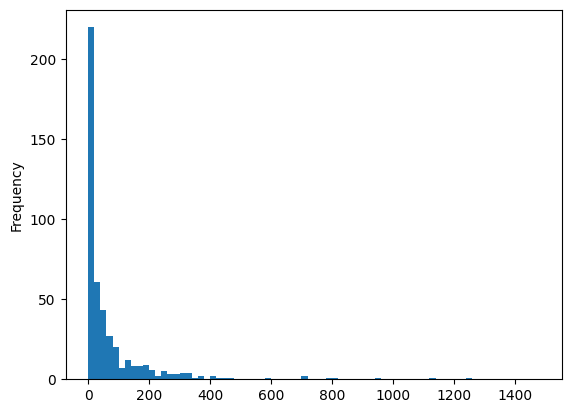

In [350]:
lr_community_belonging_rate.n_obs.plot.hist(bins=np.arange(0, 1500, 20))

In [351]:
lr_community_belonging_rate.sort_values('rate_q1', ascending=False).head(20)

,search_id,main_lr_community,n_obs,n_conv,rate,rate_q1,rate_mean
94,canapechesterfield,29489,417,383,0.918465,0.882220,0.917130
81,canapeavecpouf,23639,22,22,1.000000,0.818547,0.970313
182,canapedangleconvertibleavecvraimatelas,43109,74,68,0.918919,0.816613,0.911467
335,clicclacconvertible,35041,19,19,1.000000,0.794328,0.965936
441,plaidpourcanape3places,30699,16,16,1.000000,0.762699,0.960047
281,canaperelax3placeselectrique,27901,15,15,1.000000,0.749894,0.957603
454,runecanape,42155,13,13,1.000000,0.719686,0.951695
431,houssesdecanapeextensible,39971,104,82,0.788462,0.683111,0.784804
392,houssedecanape3place,48024,179,136,0.759777,0.679049,0.757854
285,canaperelaxelectrique,27901,16,15,0.937500,0.668367,0.903218


In [273]:
lr_infos = exploded_lr_df.dropna().groupby('search_id', as_index=True).community_id.apply(lambda x: x.value_counts(normalize=True).head(5)).reset_index()
lr_infos['community_id'] = lr_infos.apply(lambda x: f"{x['level_1']}: {x['community_id']}", axis=1)
lr_infos.drop(columns='level_1', inplace=True)
lr_infos = lr_infos.groupby('search_id').apply(lambda x: list(x.community_id)).rename("top_community_id_list").reset_index()
lr_infos

,search_id,top_community_id_list
0,achetercanapepascher,"[11232: 0.4, 23639: 0.15, 7886: 0.1, 46543: 0...."
1,auc0755886164390,"[48024: 0.7142857142857143, 12157: 0.142857142..."
2,auc8737752324949,[1419: 1.0]
3,banquetteclicclac,"[35041: 0.25, 22900: 0.17708333333333334, 8416..."
4,banquetteclicclac3places,"[7886: 0.425531914893617, 22900: 0.14893617021..."
...,...,...
457,salondangle,"[43187: 0.6923076923076923, 10866: 0.153846153..."
458,salonpanoramique,"[47533: 0.3333333333333333, 43187: 0.333333333..."
459,serviettedecanape,"[1419: 0.46808510638297873, 12157: 0.276595744..."
460,sofa,"[24698: 0.14705882352941177, 27062: 0.13970588..."


In [57]:
def look4one_community(idx):
    row = communities_df.loc[idx]
    row_infos = infos.loc[idx]
    print("\n\t------INFOS------")
    print(f"Mean: {row_infos.dmean} | Median: {row_infos.dmedian} | Density: {row_infos.density} | Community_size: {row.community_size}\n",
          f"| Quantile 25%: {row_infos.quantile_025} | Quantile 95%: {row_infos.quantile_095} | Quantile 5%: {row_infos.quantile_005}")
    print("\t------TOP_SEARCH_IDs------")
    for s_id in row.top_search_id_list:
        print(f"{s_id}")
    print("\t------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:25]
    for product in products_list:
        print(product)
    print(end="\n\n" + "-" * 150 + "\n")
    
def look4one_lr(search_id):
    row = lr_infos[lr_infos.search_id == search_id]
    print("\n\t------INFOS------")
    print("\t------TOP_SEARCH_IDs------")
    for community_id in row.top_community_id_list:
        print(f"{community_id}")

In [220]:
temp_df = full_df
#temp_df.set_index('search_id', inplace=True)
temp_df = temp_df.groupby('search_id').community_id.apply(lambda x: x.value_counts().head(5)).reset_index()
#temp_df.rename(columns={'community_id':'com_id'}, inplace=True)
temp_df.sort_values('community_id', ascending=False, inplace=True)
display(temp_df)
del temp_df

,search_id,level_1,community_id
114,canape3places,10866,866
115,canape3places,11568,568
28,canape,27062,551
29,canape,7886,504
30,canape,8416,493
...,...,...,...
1361,houssebz140avecfermetureeclair,44695,1
1362,houssebz140avecfermetureeclair,32533,1
1364,houssebz140x190,25909,1
1365,houssebz160,41085,1


In [384]:
print(infos.columns)
infos.sort_values('density', inplace=True, ascending=False)
community_ids = communities_df[communities_df.community_size < 40].index
print(f"Number of total community is: {len(community_ids)}")
for community_idx in community_ids:
    look4one_community(community_idx)
    

Index(['dmean', 'dmedian', 'quantile_025', 'quantile_095', 'quantile_005',
       'community_size', 'len_edges', 'density'],
      dtype='object')
Number of total community is: 29

	------INFOS------
Mean: 0.9573692650558953 | Median: 0.9965486517054298 | Density: 0.9868421052631579 | Community_size: 38
 | Quantile 25%: 0.9733240365049629 | Quantile 95%: 0.9997520574347352 | Quantile 5%: 0.7299089269094632
	------TOP_SEARCH_IDs------
canape: 0.8157894736842105
canapee: 0.07894736842105263
canaper: 0.05263157894736842
canapemodulable: 0.02631578947368421
canapes: 0.02631578947368421
	------PRODUCTS_NAME_SAMPLE------
qid canape central sectionnel avec_coussins bois impregne de gris qid11913
moh canapes centraux de jardin avec_coussins 2pcs gris bois de pin
canape central sectionnel avec_coussins bois impregne de vert 3074518
betteve canape central sectionnel et coussins gris fonce bois d acacia
qid canape central sectionnel avec_coussins bois impregne de gris qid11912
canape central sect